In [1]:
#Importamos las librerias necesarias
import re
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as grb
from gurobipy import GRB
from timeit import timeit
from time import time

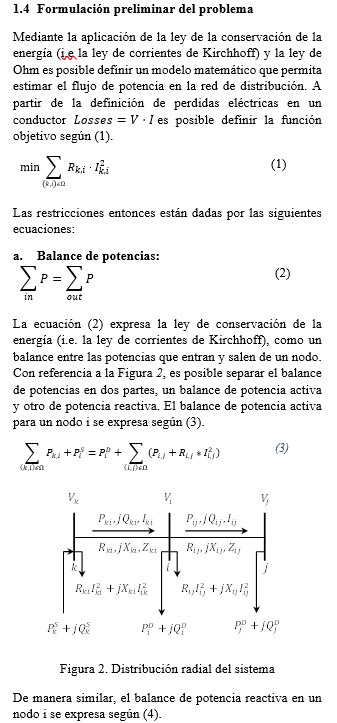

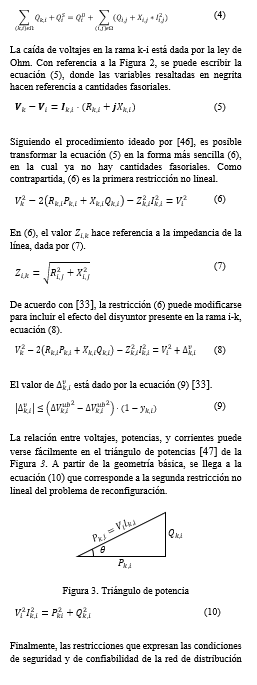

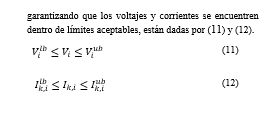

In [2]:
#Vamos creando aqui la clase
class DistributionNetwork():
    def __init__(self,ruta,b):
        self.b=b#parametro de tunning restriccion cespedes.
        self.ruta=ruta
        file=open(self.ruta)#abre el archivo
        datos=file.readlines()#lee el contenido del archivo
        file.close()#cierra el archivo
        #Ahora determinamos los inicios y finales de las tablas de ramas y potencias:
        #primero declaramos algunas variables utiles:
        nodo_ref=0
        index_inicio_ramas=0
        index_final_ramas=0
        index_inicio_potencias=0
        index_final_potencias=0
        datos_ramas=[]
        datos_potencias=[]
        
        #determinamos el inicio y final de la tabla de ramas:
        for index, line in enumerate(datos):#Hallamos el inicio y el final de la tabla de datos de la red
            if line.startswith("ramos = ["):
                index_inicio_ramas=index
                print(index_inicio_ramas)
            if line.endswith("];\n"):
                index_final_ramas=index
                print(index_final_ramas)
                break
        #determinamos el inicio y final de la tabla de potencias:
        for index, line in enumerate(datos):#Hallamos el inicio y el final de la tabla de datos de potencia
            if line.startswith("barras"):
                index_inicio_potencias=index
                print(index_inicio_potencias)
            if (line.endswith("];\n")| line.endswith("];")) and index_inicio_potencias!=0:
                index_final_potencias=index
                print(index_final_potencias)
                break
        print(index_inicio_ramas)
        #Ahora si, extraemos todos los datos necesarios del archivo:
        for index, line in enumerate(datos):#itera sobre cada una de las lineas de datos
            if line.startswith("""% Datos globales"""):
                self.nodo_ref=int(re.findall('\d{1,3}',datos[index+1])[0])#almacena el atributo nodo de referencia
                self.v_ref=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+2])[0])#almacena el atributo voltaje de referencia
                self.v_base=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+3])[0])*1000#almacena el atributo voltaje base
                self.s_base=float(re.findall('\d+',datos[index+4])[0])*1000#almacena el atributo potencia aparente base
                self.tol=float(re.findall('\d{1,2}\^\-\d{1}',
                                          datos[index+5])[0][0:2])**float(re.findall('\d{1,2}\^\-\d{1}',
                                                                                    datos[index+5])[0][3:5])#almacena el atributo tolerancia
                #self.v_min=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+6])[0])#almacena el atributo voltaje minimo
                self.v_min=0
                
                #self.v_max=float(re.findall('\d{1,2}\.\d{1,2}',datos[index+7])[0])#almacena el atributo voltaje_maximo
                self.v_max=1
                #self.v_max=1.5
                self.z_base=(self.v_base)**2/(self.s_base)#calcula la impedancia base a partir de la ley de ohm
                self.i_max=5
                #extraemos los datos de las ramas:
            if index>=index_inicio_ramas and index<=index_final_ramas:#extraemos los datos de las ramas
                nodos=re.findall("\d{1,3}",line)
                impedancia=re.findall("\d{1,3}\.\d{1,7}",line)
                datos_ramas.append([nodos[0],nodos[1],impedancia[0],impedancia[1]])
            #extrae los datos de las potencias
            if index>=index_inicio_potencias and index<=index_final_potencias:
                lista_re=re.findall("\d+\.*\d*",line)
                datos_potencias.append([lista_re[0],lista_re[1],lista_re[2],lista_re[3]])
            #creamos dos dataframes:
            #print(datos_ramas)
            self.ramas=pd.DataFrame(datos_ramas,columns=["nodo_i","nodo_j","R","X"])#creamos los dataframes de ramas y potencias
            self.potencias=pd.DataFrame(datos_potencias,columns=["nodo","Pd","Qd","Qbc"])
            #Ajustamos el tipo de dato de todas las columnas a ser float64
            self.potencias.nodo=self.potencias.nodo.astype("float")
            self.potencias.Pd=self.potencias.Pd.astype("float")*1000
            self.potencias.Qd=self.potencias.Qd.astype("float")*1000
            self.potencias.Qbc=self.potencias.Qbc.astype("float")*1000
            self.ramas.nodo_i= self.ramas.nodo_i.astype("float")
            self.ramas.nodo_j= self.ramas.nodo_j.astype("float")
            self.ramas.R= self.ramas.R.astype("float")
            self.ramas.X= self.ramas.X.astype("float")
            
            #Generamos a continuacion la red
        self.generar_red()
        #Generamos el modelo de gurobi
        self.generar_modelo_base()
        self.generar_variables_disyuntores()#Generemos la variable y_ij asociada al estado de los disyuntores
        self.generar_variables_potencia_ij()#Generamos la variable P_ij, asociada a la potencia activa de i a j
        self.generar_variable_Q_ij()#Generamos la variable Q_ij asociada a la potencia reactiva de i a j
        #self.generar_variables_V_i()#Generamos la vairable V_i, asociada al voltaje del nodo i
        self.generar_variables_Vsqr_i()#Generamos la variable Vsqr, asociada al cuadrado del voltaje del nodo i
        #self.generar_variables_I_ij()#Generamos la variable I_ij, asociada a la corriente del arco i,j
        self.generar_variables_I_sqr()#Genermos la variable I_ij_sqr asociada al cuadrado de la corriente del arco ij
        self.generar_variable_delta_ij()
        #A continuación generamos las restricciones del problema
        self.generar_restriccion_corrientes_sqr()
        self.generar_restriccion_un_solo_arco_ij()
        self.generar_restriccion_triangulo_potencia()
        self.generar_restriccion_delta()
        self.generar_restriccion_Ohm()
        self.balance_reactiva()
        self.balance_activa()
        #self.modelo.addConstr(self.voltajes_sqr[14]==1)#Fijamos el voltaje de la subestacion en 1 p.u
        #self.restriccion_auxiliar()
        #Actualizar el modelo
        self.modelo.update()
        #Escribir el reporte del modelo
        self.generar_reporte()
        #Optimizar
        self.optimizar()
    def generar_red(self):
        #En esta seccion generamos la red:
        self.Red=nx.DiGraph()#Creamos un elemento digraph
        #Recorremos primero la tabla de ramas:
        for element in self.ramas.itertuples():
            self.Red.add_edge(element[1],element[2])#añade el arco de i a j
            self.Red.add_edge(element[2],element[1])#añade el arco de j a i
            #Ahora añadimos la resistencia y la impedancia
            self.Red.edges[element[1],element[2]]["R"]=element[3]/self.z_base#*self.z_base#Añadimos la resistencia al arco ij
            self.Red.edges[element[1],element[2]]["X"]=element[4]/self.z_base#*self.z_base#Añadimos la inductancia al arco ij
            self.Red.edges[element[2],element[1]]["R"]=element[3]/self.z_base#*self.z_base#Añadimos la resistencia al arco ij
            self.Red.edges[element[2],element[1]]["X"]=element[4]/self.z_base#*self.z_base#Añadimos la inductancia al arco ij
        #Ahora recorremos la tabla de potencias
        for element in self.potencias.itertuples():
            self.Red.nodes[element[1]]["Pd"]=element[2]/self.s_base#Añadimos la demanda de potencia activa en el nodo
            self.Red.nodes[element[1]]["Qd"]=element[3]/self.s_base#Añadimos la demanda de potencia reactiva en el nodo
            self.Red.nodes[element[1]]["Qbc"]=element[4]/self.s_base#Añadimos el Qbc del nodo
    def graficar_red(self):
        nx.draw(self.Red, pos=nx.kamada_kawai_layout(self.Red),with_labels=True)
        plt.show()
    def generar_modelo_base(self):
        #Se crea un objeto modelo de gurobipy
        self.modelo=grb.Model(self.ruta[0:-4])
    def generar_variables_disyuntores(self):
        #En esta parte creamos la variable disyuntores 
        self.y=self.modelo.addVars(list(self.Red.edges),vtype=GRB.BINARY, name="estado_disyuntor",ub=1)
    def generar_variables_potencia_ij(self):
        self.pot=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="potencia_activa",lb=0,ub=5)
    def generar_variable_Q_ij(self):
        self.q=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="potencia_reactiva",lb=0,ub=5)
    def generar_variables_V_i(self):
        self.voltajes=self.modelo.addVars(list(self.Red.nodes),vtype=GRB.CONTINUOUS, name="voltaje",ub=self.v_max*self.v_base,
                                         lb=self.v_min*self.v_base)
    def generar_variables_Vsqr_i(self):
        self.voltajes_sqr=self.modelo.addVars(list(self.Red.nodes),vtype=GRB.CONTINUOUS, name="voltaje_sqr",
                                              lb=(self.v_min)**2,
                                              
                                              ub=(self.v_max)**2)
    def generar_variables_I_ij(self):
        self.corrientes=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="corriente",ub=self.i_max)
    def generar_variables_I_sqr(self):
        lista_resistencias=[element[2]["R"] for element in self.Red.edges.data()]#Generamos una lista con las resistencias de los arcos
        self.corrientes_sqr=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS, name="corriente_sqr",
                                                obj=lista_resistencias,lb=0,ub=self.i_max**2)
    def generar_variable_delta_ij(self):
        b_abs=abs(self.v_max-self.v_min)
        self.delta=self.modelo.addVars(list(self.Red.edges),vtype=GRB.CONTINUOUS,name="delta",lb=-b_abs,ub=b_abs)
    def generar_reporte(self):
        self.modelo.write("reporte.lp")
        print("model written!!")
    def generar_restriccion_corrientes_sqr(self):
        #Esta función genera la restricción I_sqr<=I_ij**2
        for row in self.ramas.itertuples():#iteramos sobre el dataframe de ramas
            nodo_i=row[1]
            nodo_j=row[2]
            self.modelo.addConstr(self.corrientes_sqr[(nodo_i,nodo_j)]<=self.y[(nodo_i,nodo_j)]*self.i_max**2)#Restriccion del
            #arco ij
            self.modelo.addConstr(self.corrientes_sqr[(nodo_j,nodo_i)]<=self.y[(nodo_j,nodo_i)]*self.i_max**2)#Restriccion del
            #arco ij
    def generar_restriccion_un_solo_arco_ij(self):
        #Esta funcion genera la restriccion y_ij+y_ji=1
      
        #self.modelo.addConstr(grb.quicksum(self.y[edge] for edge in self.Red.edges())==len(self.Red.nodes())-1)
        for nodo in self.Red.nodes:
            if nodo!=self.nodo_ref:
                
                self.modelo.addConstr(self.y.sum('*',nodo)==1)
               
            else:
                self.modelo.addConstr(self.y.sum(nodo,'*')>=1)
        
            
    def generar_restriccion_triangulo_potencia(self):#Genera la restriccion P**2+Q**2=S**2
        for edge in self.Red.edges():
            nodo_j=edge[1]
            self.modelo.addConstr(self.voltajes_sqr[nodo_j]*self.corrientes_sqr[edge]>=(self.pot[edge])**2+(self.q[edge])**2)
    def generar_restriccion_delta(self):
        for edge in self.Red.edges():
            self.modelo.addConstr(self.b*(1-self.y[edge])>=self.delta[edge])#b*(1-y_ij)>=delta_ij
            self.modelo.addConstr(-self.b*(1-self.y[edge])<=self.delta[edge])#delta_ij>=-b*(1-y_ij)
    def generar_restriccion_Ohm(self):#Genera la restriccion de cespedes
        for edge in self.Red.edges():#Recorremos cada rama
            #Añadimos la restricción de cespedes
            nodo_i=edge[0]
            nodo_j=edge[1]
            R=self.Red.edges[edge]["R"]#Obtenemos la resistencia del arco ij
            X=self.Red.edges[edge]["X"]#Obtenemos la resistencia del arco ij
            Z_sqr=R**2+X**2#Clculamos la magnitud de la impedancia al cuadrado del arco ij
            self.modelo.addConstr(self.voltajes_sqr[nodo_i]==self.voltajes_sqr[nodo_j]+
                                  2*(R*self.pot[edge]+X*self.q[edge])-Z_sqr*self.corrientes_sqr[edge]+self.delta[edge])
    def balance_reactiva(self):#Genera la restriccion de balance de potencia reactiva
        for node in self.Red.nodes():#Iteramos sobre los nodos de la red
            if node!=self.nodo_ref:
                #Aplica para todos los nodos excepto el de referencia
                my_dict={(node,i):self.Red.edges[(node,i)]["X"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coeff = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.q.sum('*',node)-self.q.sum(node,'*')-self.corrientes_sqr.prod(coeff,node,'*')==
                                      self.Red.nodes[node]["Qd"])#Creamos la restriccion de balance de potencia reactiva
            else:#Este caso solo aplica para los nodos subestación
                my_dict={(node,i):self.Red.edges[(node,i)]["X"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coeff = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.q.sum('*',node)-self.q.sum(node,'*')-self.corrientes_sqr.prod(coeff,node,'*')<=
                                      -sum(self.potencias.Qd)/self.s_base)#Creamos la restriccion de balance de potencia reactiva
    def balance_activa(self):#Genera la restriccion de balance de potencia activa
        for node in self.Red.nodes():#Iteramos sobre los nodos de la red
            if node!=self.nodo_ref:#esta condición aplica para todos los nodos que no son subestacion
                my_dict={(node,i):self.Red.edges[(node,i)]["R"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coef = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.pot.sum('*',node)-self.pot.sum(node,'*')-self.corrientes_sqr.prod(coef,node,'*')==
                                    self.Red.nodes[node]["Pd"])#Añade la restricción de flujo de activa
            else:#Este caso solo aplica para los nodos subestacion
                my_dict={(node,i):self.Red.edges[(node,i)]["R"] for i in self.Red.nodes() if (node,i) in self.Red.edges()}
                corrientes, coef = grb.multidict(my_dict)#creamos un objeto multidict
                self.modelo.addConstr(self.pot.sum('*',node)-self.pot.sum(node,'*')-self.corrientes_sqr.prod(coef,node,'*')<=
                                    -sum(self.potencias.Pd)/self.s_base)
    def restriccion_auxiliar(self):#Esta no sirvio!
        for node in self.Red.nodes():#Iteramos sobre los nodos
            if node!=self.nodo_ref:#Para todos los nodos esxcepto el de referencia
                self.modelo.addConstr(self.y.sum('*',node)==1)
                R=self.Red.predecessors(node)
                #maxVarsList=[self.y[node,element] for elemen in R]
                #self.modelo.addGenConstrMax(1, maxVarsList, name='maxconstr_')
                #"self.modelo.addConstr(1==grb.max_(self.y[element,node] for element in R))
                self.modelo.addConstr((self.y.sum('*',node))**2-2*self.y.sum('*',node)<=-1)
                #R=self.Red.predecessors(node)
                #self.modelo.addConstr(grb.quicksum(self.y[r,node]**2 for r in R)<=1)
            else:#el nodo ref
                #self.modelo.addConstr(self.y.sum(node,'*')==3)
                pass
    def optimizar(self):
        #self.modelo.params.NonConvex = 2
        start=time()
        self.modelo.optimize()
        self.tiempo_computo=time()-start
        if self.modelo.Status == grb.GRB.INFEASIBLE:
            self.modelo.computeIIS()
            self.modelo.write('iismodel.ilp')
    def get_red_opti(self):
        self.red_optima=nx.Graph()
        for element in self.y:
            if round(self.y[element].x)==1:
                self.red_optima.add_edge(element[0],element[1])
        nx.draw(self.red_optima, pos=nx.kamada_kawai_layout(self.red_optima),with_labels=True)
        plt.show()
                
    
                
            
       
            
    
    
        
    
        
            
            
        
            
        


In [3]:
red_33=DistributionNetwork("datos33.txt",0.2)

16
52
56
88
16
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-14
model written!!
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 5 3550H with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 395 rows, 403 columns and 1406 nonzeros
Model fingerprint: 0xf6fe7376
Model has 74 quadratic constraints
Variable types: 329 continuous, 74 integer (74 binary)
Coefficient statistics:
  Matrix range     [4e-05, 3e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [6e-03, 1e-01]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e-03, 1e+00]
Presolve removed 45 rows and 45 columns
Presolve time: 0.04s
Presolved: 350 rows, 358 columns, 1304 nonzeros
Presolved model has 71 quadratic constraint(s)
Variable types: 319 continuous, 39 integer (39 binary)

Root relaxation: objective 4.405513e-04, 71 iterations, 0.01 seco

In [4]:
red_33.z_base

16.02756

In [26]:
red_33.s_base

10000000.0

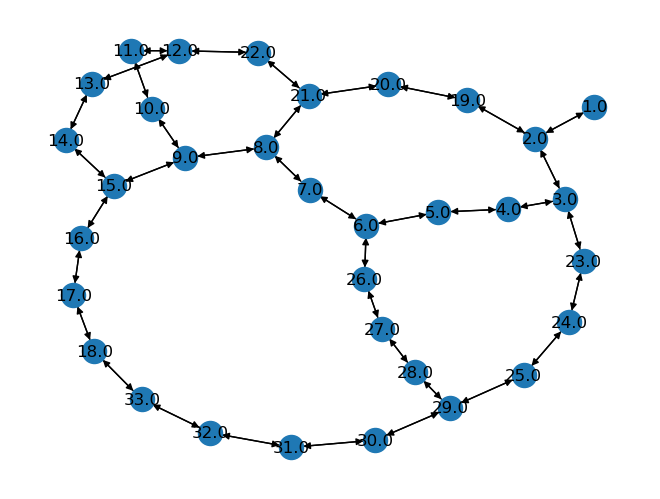

In [13]:
red_33.graficar_red()

In [14]:
len(red_33.Red.edges)

74

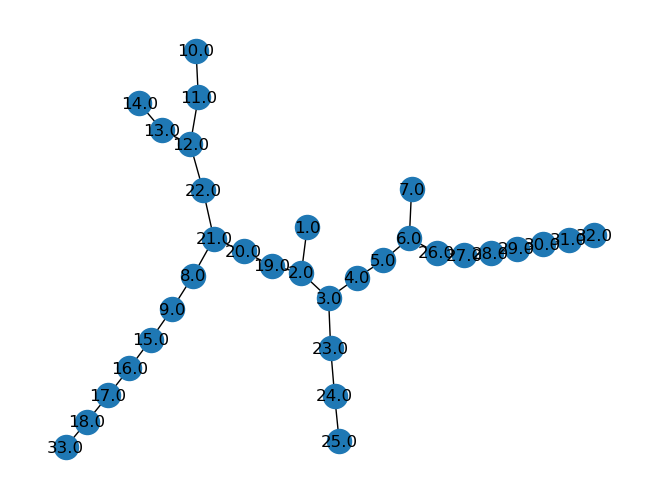

In [15]:
red_33.get_red_opti()

In [16]:
for v in red_33.modelo.getVars():
    if v.x>1e-6:
        print(v.varName,v.x)

estado_disyuntor[1.0,2.0] 1.0
estado_disyuntor[2.0,3.0] 1.0
estado_disyuntor[2.0,19.0] 1.0
estado_disyuntor[3.0,4.0] 0.9999999999998438
estado_disyuntor[3.0,23.0] 0.999999999999997
estado_disyuntor[4.0,5.0] 0.9999999999998439
estado_disyuntor[5.0,6.0] 1.0
estado_disyuntor[6.0,7.0] 1.0
estado_disyuntor[6.0,26.0] 1.0000000000000213
estado_disyuntor[8.0,9.0] 1.0
estado_disyuntor[9.0,15.0] 1.0
estado_disyuntor[11.0,10.0] 1.0
estado_disyuntor[12.0,11.0] 1.0
estado_disyuntor[12.0,13.0] 1.0
estado_disyuntor[13.0,14.0] 1.0
estado_disyuntor[15.0,16.0] 1.0
estado_disyuntor[16.0,17.0] 1.0
estado_disyuntor[17.0,18.0] 1.0000000000000806
estado_disyuntor[18.0,33.0] 1.0
estado_disyuntor[19.0,20.0] 1.0
estado_disyuntor[20.0,21.0] 1.0
estado_disyuntor[21.0,22.0] 1.0
estado_disyuntor[21.0,8.0] 1.0
estado_disyuntor[22.0,12.0] 1.0
estado_disyuntor[23.0,24.0] 1.0
estado_disyuntor[24.0,25.0] 1.0
estado_disyuntor[26.0,27.0] 1.0
estado_disyuntor[27.0,28.0] 1.0
estado_disyuntor[28.0,29.0] 1.0
estado_disyuntor[

In [17]:
red_33.tiempo_computo

0.6490488052368164

In [18]:
red_33.modelo.tune()


Solving model using baseline parameter set with TimeLimit=3600s

Testing candidate parameter set 1...

	Default parameters

Solving with random seed #1 ...
Optimize a model with 395 rows, 403 columns and 1406 nonzeros
Model fingerprint: 0xf6fe7376
Model has 74 quadratic constraints
Variable types: 329 continuous, 74 integer (74 binary)
Coefficient statistics:
  Matrix range     [4e-05, 3e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [6e-03, 1e-01]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e-03, 1e+00]
Presolve removed 45 rows and 45 columns
Presolve time: 0.01s
Presolved: 350 rows, 358 columns, 1304 nonzeros
Presolved model has 71 quadratic constraint(s)
Variable types: 319 continuous, 39 integer (39 binary)

Root relaxation: objective 4.405513e-04, 71 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    

     0     0    0.00215    0   16          -    0.00215      -     -    0s
     0     0    0.00243    0   15          -    0.00243      -     -    0s
     0     0    0.00545    0   23          -    0.00545      -     -    0s
     0     0    0.00625    0   20          -    0.00625      -     -    0s
     0     0    0.00938    0   23          -    0.00938      -     -    0s
     0     0    0.00967    0   24          -    0.00967      -     -    0s
     0     0    0.01075    0   25          -    0.01075      -     -    0s
     0     0    0.01100    0   26          -    0.01100      -     -    0s
     0     0    0.01143    0   23          -    0.01143      -     -    0s
     0     0    0.01164    0   24          -    0.01164      -     -    0s
     0     0    0.01172    0   21          -    0.01172      -     -    0s
     0     0    0.01176    0   22          -    0.01176      -     -    0s
     0     0    0.01185    0   24          -    0.01185      -     -    0s
     0     0    0.01188  

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\Users\pablo\anaconda3\lib\site-packages\ipykernel\iostream.py", line 404, in write
    self.pub_thread.schedule(lambda : self._buffer.write(string))
  File "C:\Users\pablo\anaconda3\lib\site-packages\ipykernel\iostream.py", line 205, in schedule
    self._event_pipe.send(b'')
  File "C:\Users\pablo\anaconda3\lib\site-packages\zmq\sugar\socket.py", line 491, in send
    return super(Socket, self).send(data, flags=flags, copy=copy, track=track)
  File "zmq/backend/cython/socket.pyx", line 720, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/socket.pyx", line 767, in zmq.backend.cython.socket.Socket.send
  File "zmq/backend/cython/socket.pyx", line 242, in zmq.backend.cython.socket._send_copy
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
    PyErr_CheckSignals()
KeyboardInterrupt: 



Progress so far:
  baseline: mean runtime 0.60s
  best:     mean runtime 0.42s
Total elapsed tuning time 15s (3s remaining)

-------------------------------------------------------------------------------

Testing candidate parameter set 13 ...

	Method 0

Solving with random seed #1 ... runtime 0.43s
Solving with random seed #2 ... runtime 0.53s
Solving with random seed #3 ... runtime 0.57s+

Progress so far:
  baseline: mean runtime 0.60s
  best:     mean runtime 0.42s
Total elapsed tuning time 16s (2s remaining)

-------------------------------------------------------------------------------

Testing candidate parameter set 14 ...

	CutPasses 1

Solving with random seed #1 ... runtime 0.45s
Solving with random seed #2 ... runtime 0.57s
Solving with random seed #3 ... runtime 0.41s+

Progress so far:
  baseline: mean runtime 0.60s
  best:     mean runtime 0.42s
Total elapsed tuning time 18s (0s remaining)

-----------------------------------------------------------------------------

In [19]:
red_33.modelo.getTuneResult(0)

In [20]:
red_33.modelo.write("ensayo.prm")

In [21]:
G=red_33.Red.to_undirected()

In [22]:
G.edges

EdgeView([(1.0, 2.0), (2.0, 3.0), (2.0, 19.0), (3.0, 4.0), (3.0, 23.0), (4.0, 5.0), (5.0, 6.0), (6.0, 7.0), (6.0, 26.0), (7.0, 8.0), (8.0, 9.0), (8.0, 21.0), (9.0, 10.0), (9.0, 15.0), (10.0, 11.0), (11.0, 12.0), (12.0, 13.0), (12.0, 22.0), (13.0, 14.0), (14.0, 15.0), (15.0, 16.0), (16.0, 17.0), (17.0, 18.0), (18.0, 33.0), (19.0, 20.0), (20.0, 21.0), (21.0, 22.0), (23.0, 24.0), (24.0, 25.0), (25.0, 29.0), (26.0, 27.0), (27.0, 28.0), (28.0, 29.0), (29.0, 30.0), (30.0, 31.0), (31.0, 32.0), (32.0, 33.0)])

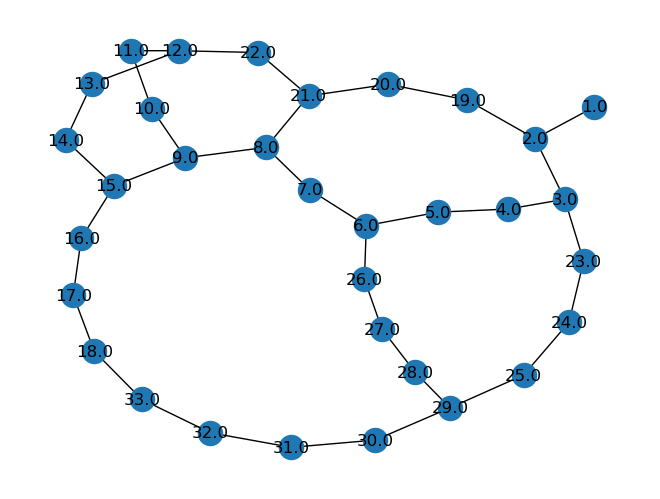

In [23]:
nx.draw(G, pos=nx.kamada_kawai_layout(G),with_labels=True)
plt.show()

In [24]:
#Lets try a minimum spanning tree
G2=nx.minimum_spanning_tree(G,"R")

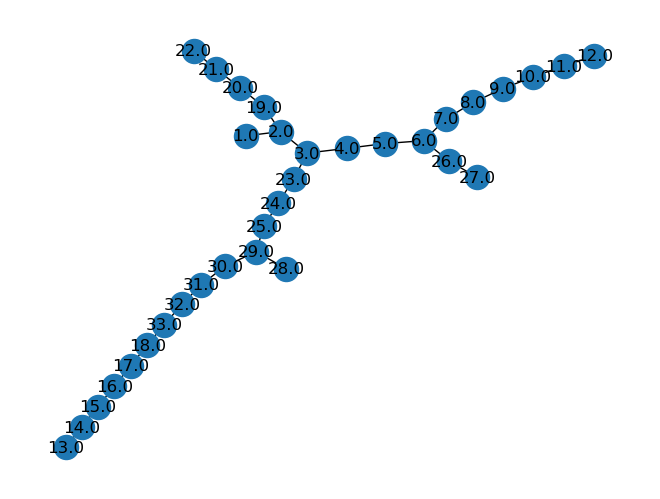

In [25]:
nx.draw(G2, pos=nx.kamada_kawai_layout(G2),with_labels=True)
plt.show()